### 1) Import dataset

In [1]:
# download kaggle data  
from google.colab import files

! pip install kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c severstal-steel-defect-detection
! ls

Saving kaggle.json to kaggle.json
 99% 1.55G/1.57G [00:09<00:00, 222MB/s]
100% 1.57G/1.57G [00:09<00:00, 176MB/s]
kaggle.json  sample_data  severstal-steel-defect-detection.zip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # 구글 드라이브에 kaggle 데이터셋 옮기기
# import os

# os.environ['KAGGLE_CONFING_DIR'] = "/content/drive/MyDrive/kaggle/"
# !mv * /content/drive/MyDrive/kaggle

# # 모든 파일 압축풀기
# !cd /content/drive/MyDrive/kaggle && unzip \*.zip

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from PIL import Image
import zipfile
import io
import cv2
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore")

fastai.__version__

'1.0.61'

#### 1) Read all text data

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle/train.csv")
sample_df = pd.read_csv("/content/drive/MyDrive/kaggle/sample_submission.csv")

In [5]:
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [6]:
train_df.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [7]:
sample_df.head()

ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0

#### 2) Check image data

In [8]:
train_size_dict = defaultdict(int)

train_path = Path("/content/drive/MyDrive/kaggle/train_images")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [9]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [10]:
test_size_dict = defaultdict(int)
test_path = Path("/content/drive/MyDrive/kaggle/test_images")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [11]:
test_size_dict

defaultdict(int, {(1600, 256): 5506})

#### 3) Visualize masks

In [12]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [30]:
def name_and_mask(start_idx):
  col = start_idx
  img_name = train_df.iloc[col,0]
  label = train_df.iloc[col, 2]
  mask = np.zeros((256, 1600,4), dtype=np.uint8)     # (세로, 가로, 채널)

  if label is not np.nan:
      mask_label = np.zeros(1600*256, dtype=np.uint8)
      label = label.split(" ")
      positions = map(int, label[0::2])   # 문자열의 슬라이싱,[start:end:step], 2 steps
      length = map(int, label[1::2])
      for pos, le in zip(positions, length):
          mask_label[pos-1:pos+le-1] = 1
      mask[:, :, train_df.iloc[col,1]-1] = mask_label.reshape(256, 1600, order='F')
  
  return img_name, mask

In [31]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

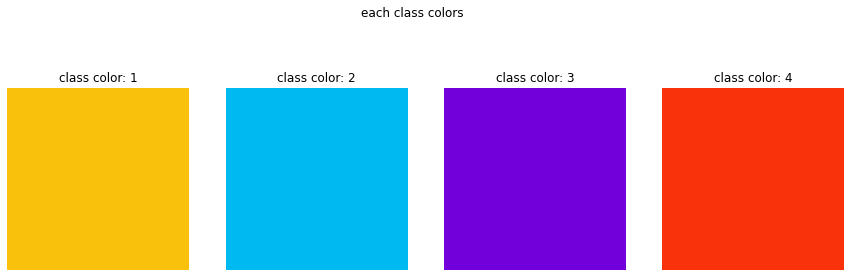

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [24]:
dup_list = pd.Series(train_df['ImageId'].value_counts())
dup_list.value_counts()

1    6239
2     425
3       2
Name: ImageId, dtype: int64

In [37]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_double = []
idx_class_triple = []

for i in range(0, len(train_df)):
  if dup_list[train_df.iloc[i,0]] == 1: 
    if train_df.iloc[i,1]==1 :
      idx_class_1.append(i)

    elif train_df.iloc[i,1]==2 :
      idx_class_2.append(i)

    elif train_df.iloc[i,1]==3 :
      idx_class_3.append(i)
    
    elif train_df.iloc[i,1]==4 :
      idx_class_4.append(i)


  elif dup_list[train_df.iloc[i,0]] == 2: 
    idx_class_double.append(i)

  elif dup_list[train_df.iloc[i,0]] == 3: 
    idx_class_triple.append(i)

#### 4) steel defect detection

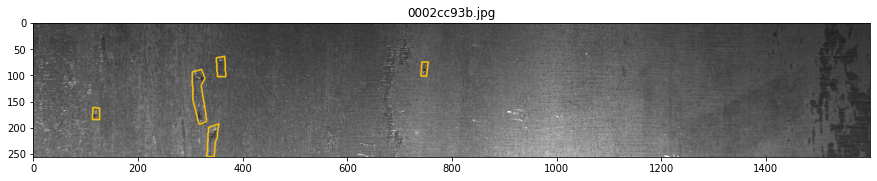

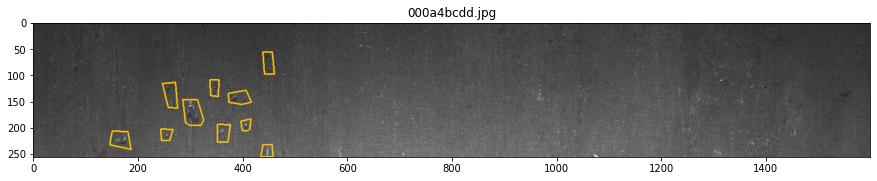

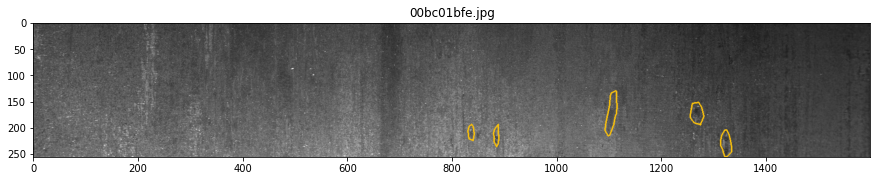

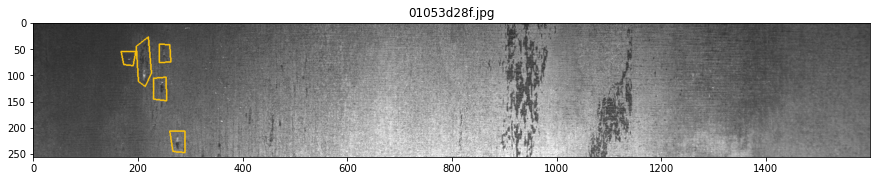

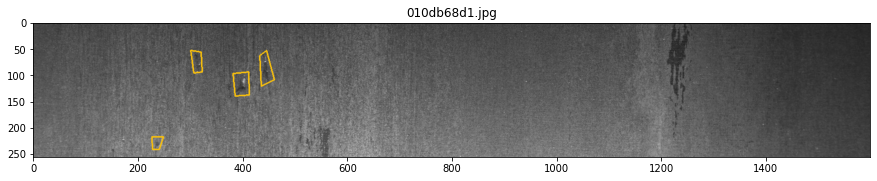

In [33]:
# Label 1
for idx in idx_class_1[:5]:
    show_mask_image(idx)

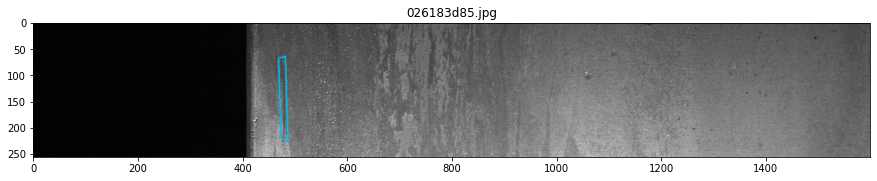

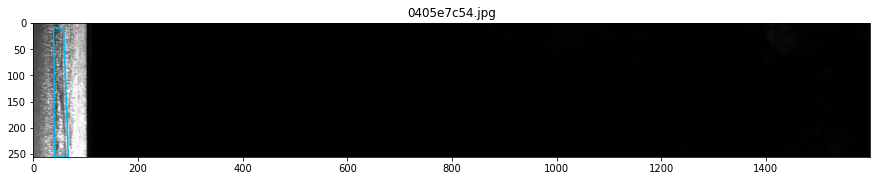

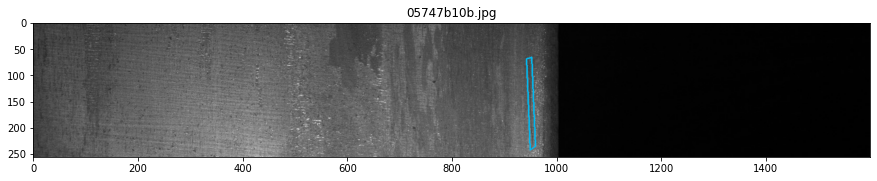

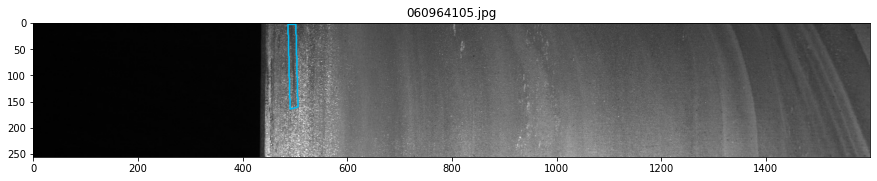

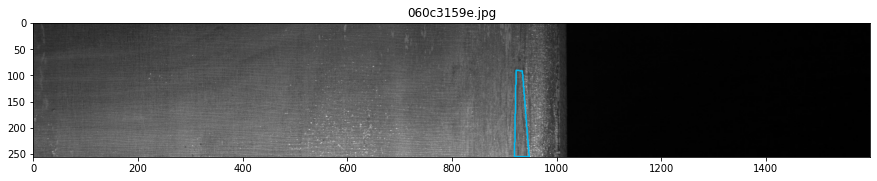

In [34]:
# Label 2
for idx in idx_class_2[:5]:
    show_mask_image(idx)

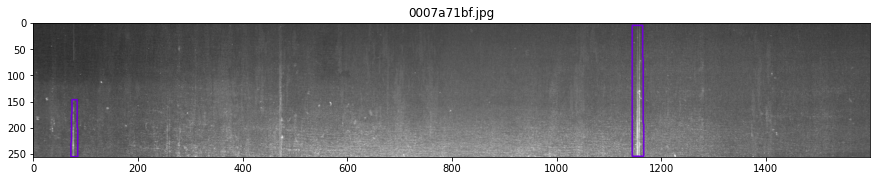

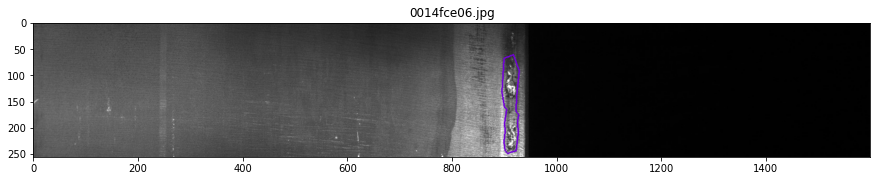

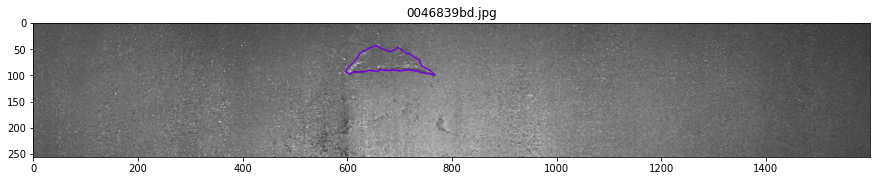

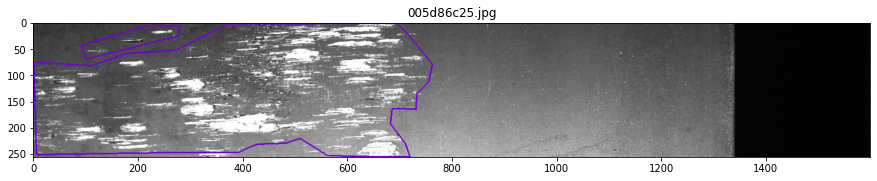

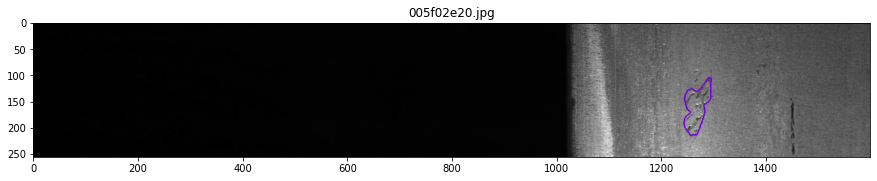

In [35]:
# Label 3
for idx in idx_class_3[:5]:
  show_mask_image(idx)

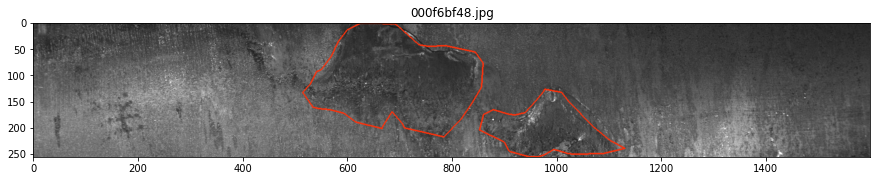

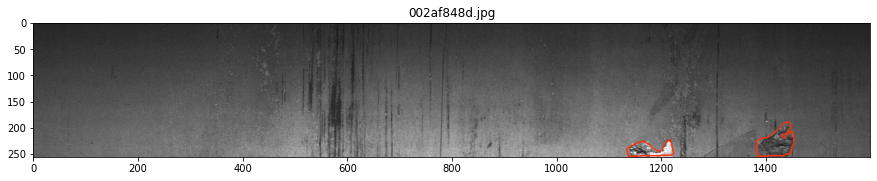

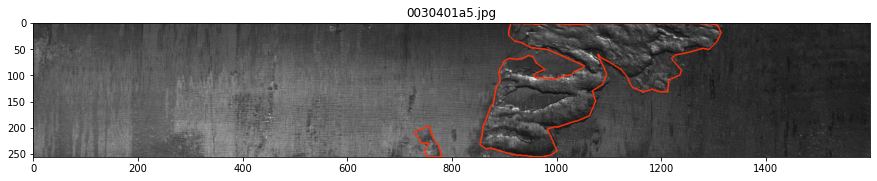

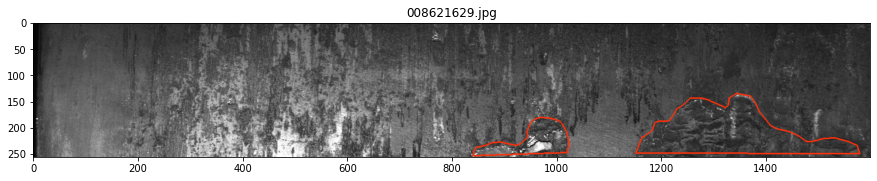

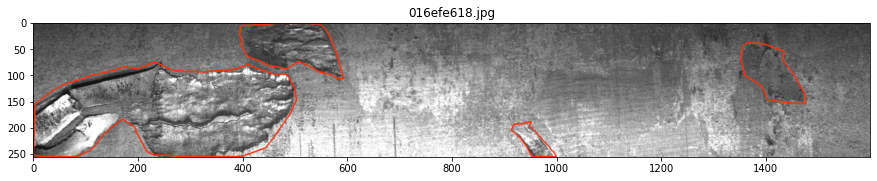

In [36]:
# Label 4
for idx in idx_class_4[:5]:
  show_mask_image(idx)

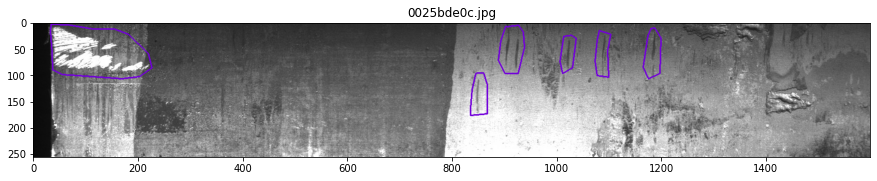

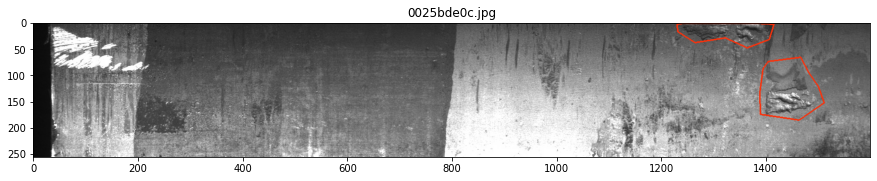

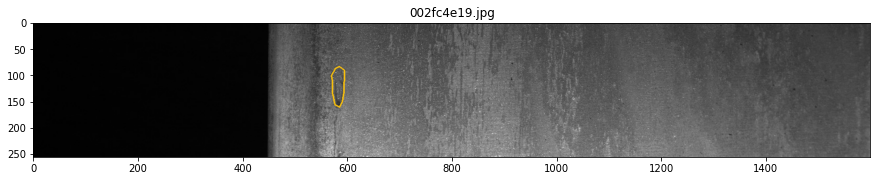

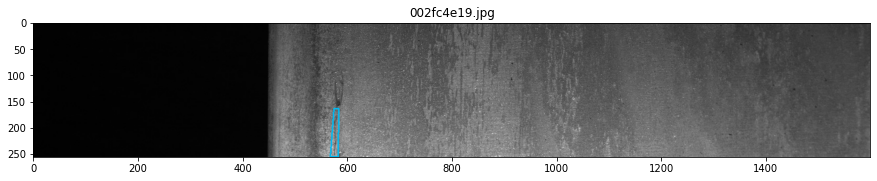

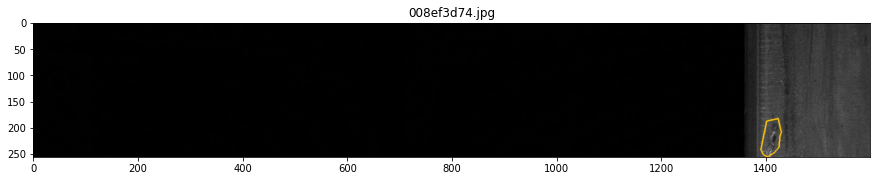

In [38]:
# double label
for idx in idx_class_double[:5]:
  show_mask_image(idx)

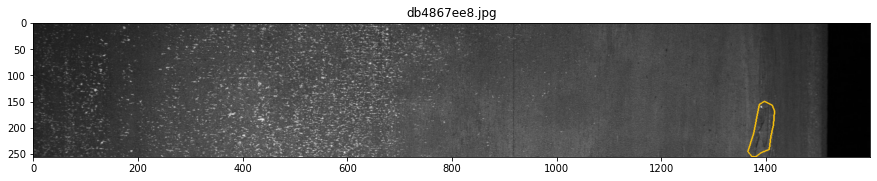

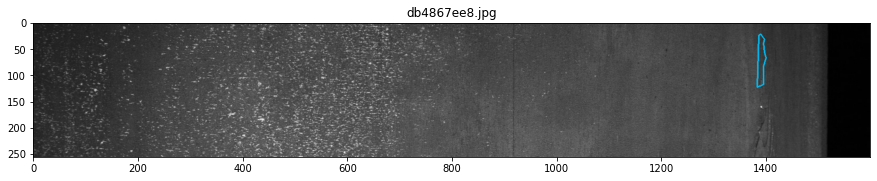

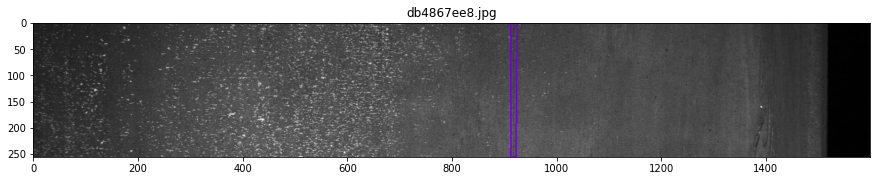

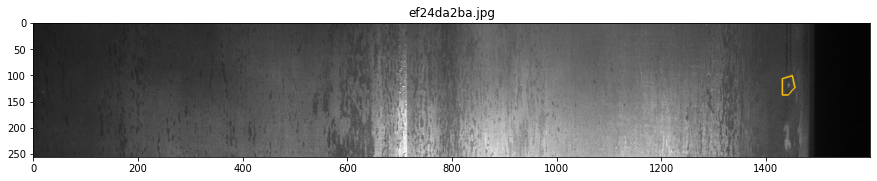

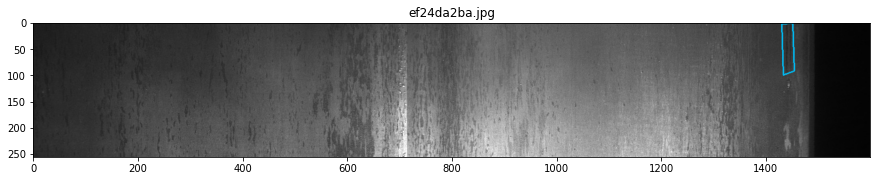

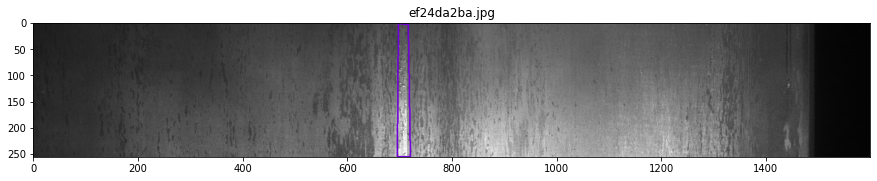

In [39]:
# triple label
for idx in idx_class_triple:
  show_mask_image(idx)